In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
# Sampling interval: (sec)
sample_interval = 0.000019531

# Load s data from the CSV file
file_name = "GOW_125_testPoint.datAcc.ch_4"
data = pd.read_csv("RAW_DATA/"+file_name+".csv", delimiter=';', header=None)
data = data.values.reshape(-1)

In [4]:
print("No. data points: ", len(data))
print("Sample duration: ", round(len(data)*sample_interval,2), "sec")

No. data points:  15411200
Sample duration:  301.0 sec


In [5]:
# Use Short-Time Fourier Transform (STFT) to extract the frequency components
nperseg = 50000*5
f, t, Zxx = signal.stft(data, fs=1/sample_interval, nperseg=nperseg)

In [6]:
# Identify the frequency bins that contain the noise and its harmonics
noise_bins = np.where((f > 190) & (f < 210))[0]
harmonics_bins = np.where((f > 380) & (f < 420))[0]
harmonics_bins_2 = np.where((f > 760) & (f < 840))[0]
combined_bins = np.concatenate((noise_bins, harmonics_bins, harmonics_bins_2))

In [7]:
# Apply a binary mask to the STFT output to zero out the noise and its harmonics
mask = np.ones(Zxx.shape)
mask[combined_bins] = 0

In [8]:
# Inverse STFT to obtain the denoised signal
_, denoised_data = signal.istft(mask * Zxx)

In [9]:
# Convert the denoised data back to the original time domain
denoised_data = np.real(denoised_data)

<Figure size 640x480 with 0 Axes>

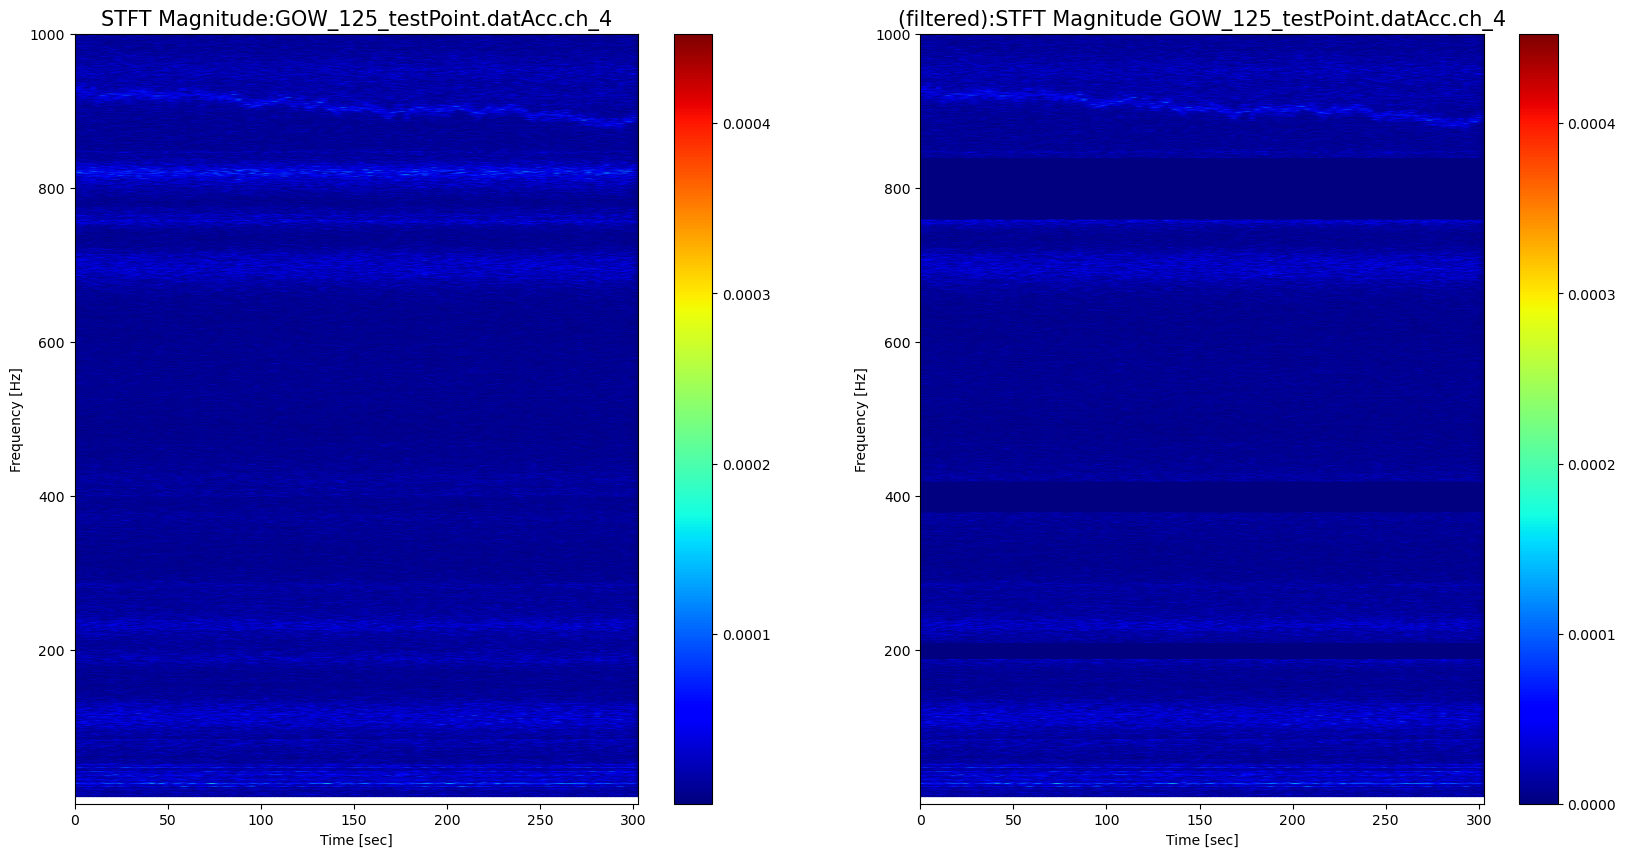

In [10]:
plt.clf()  # clearn memory to improve speed.

# plot original and denoise frequency component plot together:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('STFT Magnitude:' + file_name,fontsize=15)
plt.pcolormesh(
    t,
    f[50::],
    np.abs(Zxx)[50::],
#     vmin=1e-10,
#     vmax=1e-5,
    shading='gouraud',
)
plt.set_cmap('jet')
plt.xlabel('Time [sec]',fontsize=10)
plt.ylabel('Frequency [Hz]',fontsize=10)
plt.ylim(1, 1000)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('(filtered):STFT Magnitude ' + file_name, fontsize=15)
plt.pcolormesh(
    t,
    f[50::],
    np.abs(mask * Zxx)[50::],
#     vmin=1e-10,
#     vmax=1e-5,
    shading='gouraud',
)
plt.set_cmap('jet')
plt.xlabel('Time [sec]',fontsize=10)
plt.ylabel('Frequency [Hz]',fontsize=10 )
plt.ylim(1, 1000)
plt.colorbar()
plt.show()

<Figure size 640x480 with 0 Axes>

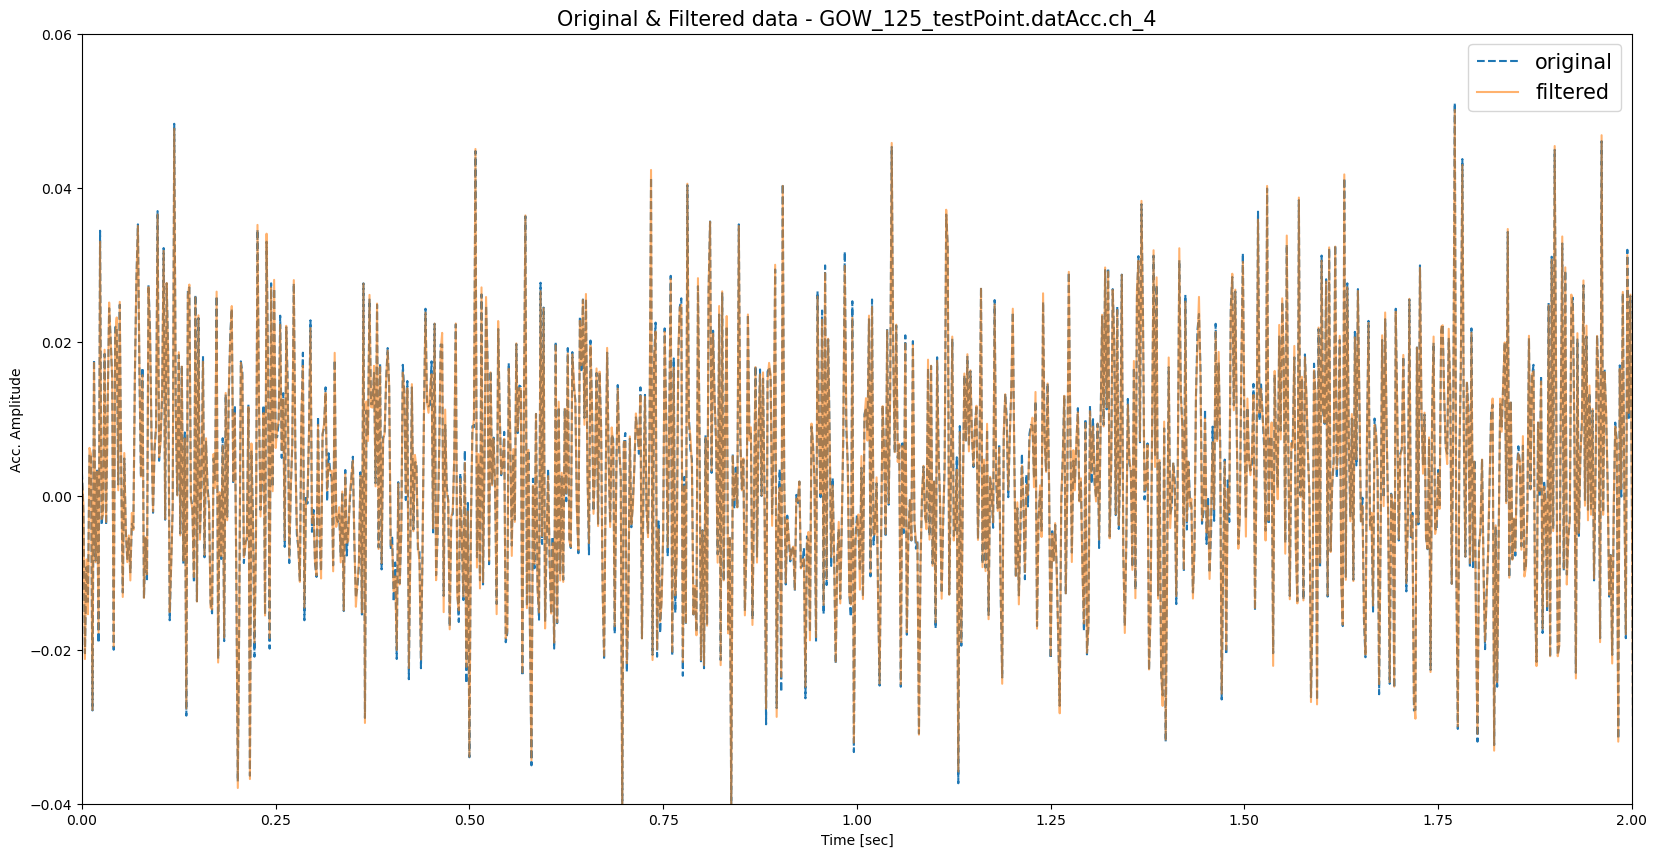

In [11]:
plt.clf()

# plot original and filtered data:

n_interval = 100  # down sampling the data to improve plot speed.

# x, y data for plot original data:
y_value = data.tolist()[::n_interval]
x_value = np.array([*range(0, len(y_value))
                    ]) * n_interval * sample_interval  # in unit sec.

# x, y data for plot original data:
y_filter_value = denoised_data.tolist()[::n_interval]
x_filter_value = np.array([*range(0, len(y_filter_value))
                           ]) * n_interval * sample_interval  # in unit sec.

# plot
plt.figure(figsize=(20, 10))
plt.plot(x_value, y_value, label="original", linestyle='--')  #  linewidth=4)
plt.plot(x_filter_value, y_filter_value, label="filtered", alpha=0.6)
plt.title("Original & Filtered data - " + file_name, fontsize=15)
plt.xlabel("Time [sec]")
plt.ylabel("Acc. Amplitude")
plt.legend(loc="best", fontsize=15)
plt.xlim([0, 2])  # comment out to see full plot.
plt.ylim([-0.04, 0.06])
plt.show()

<Figure size 640x480 with 0 Axes>

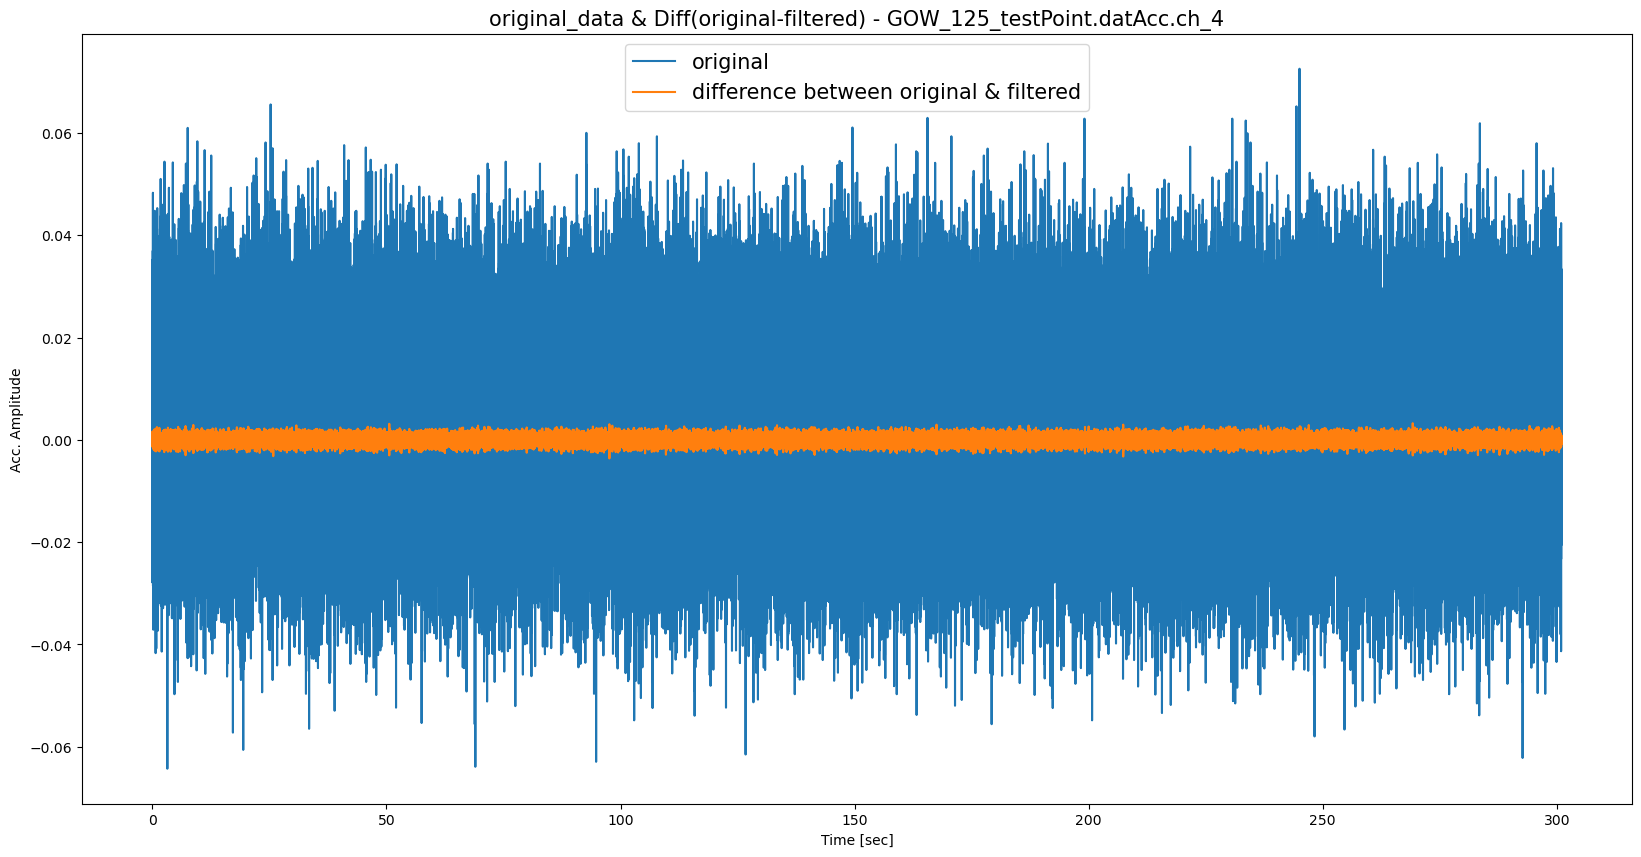

In [12]:
# Subtraction of denoised data from original data
filtered_out = data - denoised_data[0:len(data)]
y_filtered_out = filtered_out.tolist()[::n_interval]  # down sampling
x_filtered_out_value = np.array([*range(0, len(y_filtered_out))
                             ]) * n_interval * sample_interval  # in unit sec

# plot original and substraction data
plt.clf()
plt.figure(figsize=(20, 10))
plt.plot(x_value, y_value, label="original")
plt.plot(x_filtered_out_value, y_filtered_out, label="difference between original & filtered")
plt.title("original_data & Diff(original-filtered) - " + file_name, fontsize=15)
plt.xlabel("Time [sec]")
plt.ylabel("Acc. Amplitude")
plt.legend(loc="best", fontsize=15)
plt.show()

<Figure size 640x480 with 0 Axes>

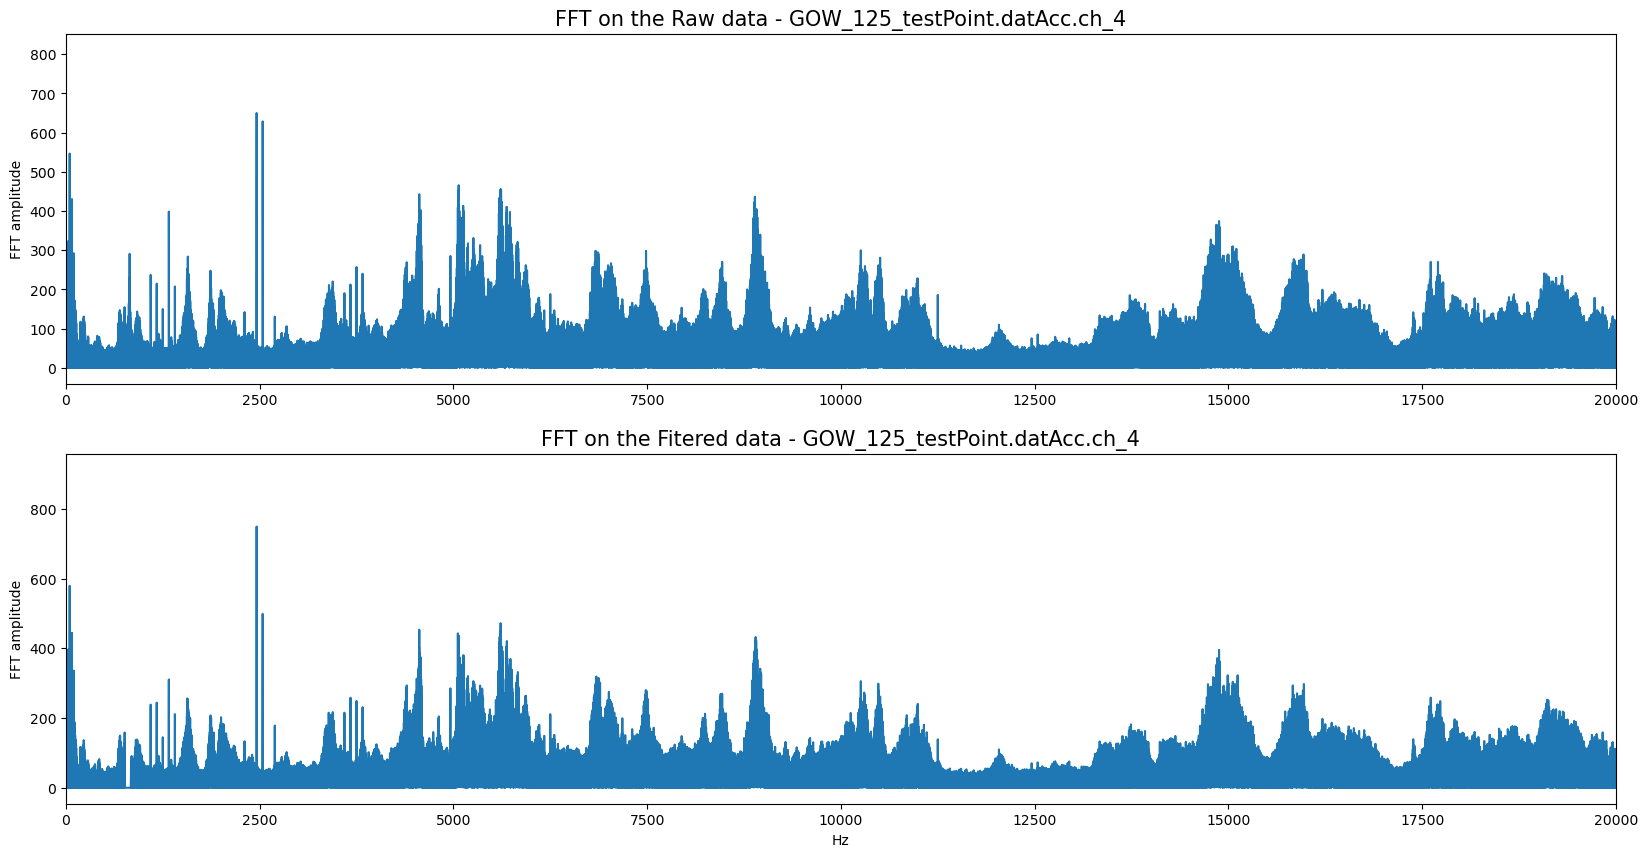

In [28]:
# performing fft on original data
import scipy.fft

sr = 1 / sample_interval  # sampling rate (Hz)

# FFT on raw data:
X = scipy.fft.fft(data)  # fft performed
n = np.arange(len(X))  #length of fft
T = len(X) / sr  # sampling period
x_freq = n / T

# FFT on filtered data:
X_filtered = scipy.fft.fft(denoised_data)  # fft performed
n_filtered = np.arange(len(X_filtered))  #length of fft
T_filtered = len(X_filtered) / sr  # sampling period
x_freq_filtered = n_filtered / T_filtered

# plot FFT spectrums:
freq_upper_range = 20000  # max. frequency in plot

plt.clf()
plt.figure(figsize=(20, 10))

plt.subplot(2,1,1)
plt.title("FFT on the Raw data - " + file_name, fontsize=15 )
plt.plot(x_freq[2:len(X) // 2], np.abs(X[2:len(X) // 2]))
plt.xlim([0, freq_upper_range])  
# plt.xlabel("Hz")
plt.ylabel("FFT amplitude")

plt.subplot(2,1,2)
plt.title("FFT on the Fitered data - " + file_name, fontsize=15 )
plt.plot(x_freq_filtered[2:len(X_filtered) // 2], np.abs(X_filtered[2:len(X_filtered) // 2]))
plt.xlim([0, freq_upper_range]) 
plt.xlabel("Hz")
plt.ylabel("FFT amplitude")

plt.show()

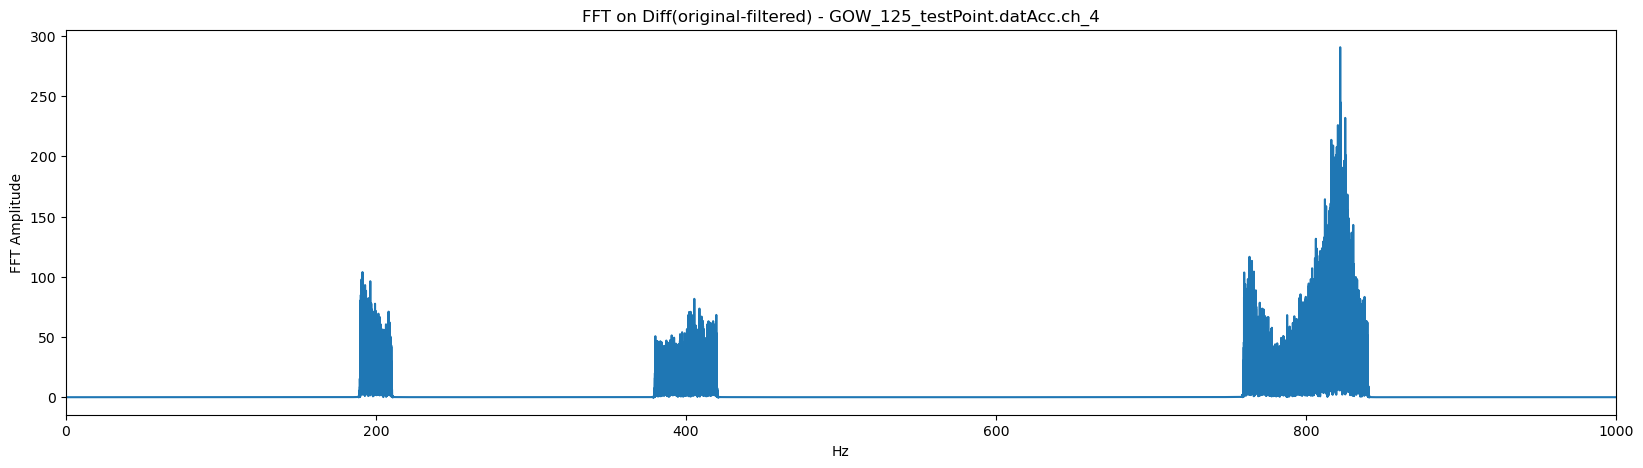

In [13]:
# performing fft on substraction data
# This is the supposed noise
import scipy.fft
sr = 1/0.000019531 # sampling rate (Hz)
X_filtered_out = scipy.fft.fft(filtered_out) # fft performed
n_filtered_out = np.arange(len(X_filtered_out)) #length of fft
T_filtered_out = len(X_filtered_out)/sr # sampling period
x_freq_filtered_out = n_filtered_out/T_filtered_out

plt.figure(figsize=(20,5))
plt.title("FFT on Diff(original-filtered) - "+ file_name)
plt.plot(x_freq_filtered_out[:len(X_filtered_out)//2+1], np.abs(X_filtered_out[:len(X_filtered_out)//2+1]))  
plt.xlabel("Hz")
plt.ylabel("FFT Amplitude")
plt.xlim([0, 1000]) 
plt.show()

Top 17 Amplitudes:  [912.55024863 749.1711939  472.2151077  453.3082821  442.99281599
 432.54298549 395.55123974 319.09444791 310.60326333 305.86828829
 297.69819438 280.27238031 269.85715353 258.5428597  258.40238241
 252.8047708  240.65305669]
Top 17 Frequencies:  [9.90980426e-03 2.46096446e+03 5.60938194e+03 4.55960995e+03
 5.05763707e+03 8.89945678e+03 1.48792540e+04 6.84429550e+03
 1.32814500e+03 1.02568093e+04 1.59743204e+04 7.48275116e+03
 8.46774606e+03 1.76105414e+04 3.67191281e+03 1.91135119e+04
 1.09920540e+04]


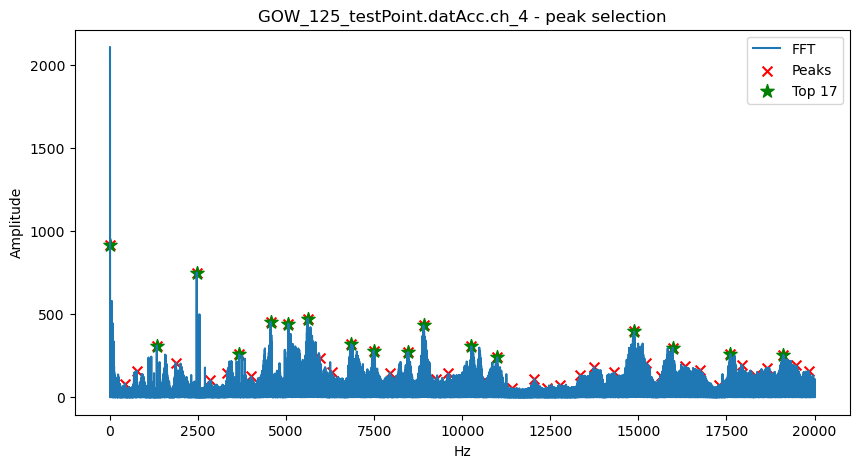

In [31]:
import scipy.signal

# performing fft on filtered data/ denoised data
sr = 1/0.000019531 # sampling rate (Hz)
X = scipy.fft.fft(denoised_data) # fft performed
n = np.arange(len(X)) #length of fft
T = len(X)/sr # sampling period
x_freq = n/T

# find peaks in the plot
peaks, props = scipy.signal.find_peaks(np.abs(X[:int(len(X)*20000//sr)]), height=5, distance=100000)

# Get the amplitudes and frequencies of the peaks
peak_amplitudes = props['peak_heights']
peak_frequencies = x_freq[peaks]

# Sort the peak amplitudes in descending order
sorted_indices = np.argsort(-peak_amplitudes)

# Get the top 10 amplitudes and their corresponding frequencies
top_17_amplitudes = peak_amplitudes[sorted_indices[:17]]
top_17_frequencies = peak_frequencies[sorted_indices[:17]]

# Print the top 10 amplitudes and frequencies
print("Top 17 Amplitudes: ", top_17_amplitudes)
print("Top 17 Frequencies: ", top_17_frequencies)

plt.figure(figsize=(10,5))
plt.title("GOW_125_testPoint.datAcc.ch_4 - peak selection")
plt.plot(x_freq[1:int(len(X)*20000//sr)+1], np.abs(X[1:int(len(X)*20000//sr)+1]))
plt.xlabel("Hz")
plt.ylabel("Amplitude")

# mark the peaks
plt.scatter(x_freq[peaks], np.abs(X[peaks]), c='r', marker='x', s=50)


# Show the top 11 peaks as stars
plt.scatter(top_17_frequencies, top_17_amplitudes, marker='*', c='g', s=100)

# Show the top 11 peaks as circles
#plt.scatter(top_11_frequencies, top_11_amplitudes, marker='o', c='y', s=50)

# Add a legend to the plot
plt.legend(['FFT', 'Peaks', 'Top 17', 'Top 17 Circles'])



plt.show()

In [32]:
# # Save the top 10 peak frequencies as a row in a csv file
# import csv
# with open("peak_frequencies.csv", "w", newline="") as f:
#     writer = csv.writer(f)
#     writer.writerow(top_11_frequencies)

NameError: name 'top_11_frequencies' is not defined